## Introduction to Deep Learning - Week 5: Kaggle Mini Project

# I'M SOMETHING OF A PAINTER MYSELF - Use GANs to create art: will you be the next Monet?


This project focuses on using Generative Adversarial Networks (GANs) to generate art in the style of Claude Monet. A GAN consists of two competing neural networks: a generator that creates images and a discriminator that evaluates them. Through this adversarial process, the generator learns to produce increasingly realistic Monet-style paintings. The goal is to train the model to generate between 7,000 and 10,000 high-quality images that convincingly replicate Monet’s artistic style.

# Environment settings and libraries imports

In [ ]:
! pip install pandas numpy matplotlib seaborn scikit-learn tensorflow

In [ ]:
# Libraries import
import tensorflow as tf
import os, random, json, PIL, shutil, re
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow.keras.layers as L
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from IPython.display import Image
from PIL import Image as PILImage
import pandas as pd
import seaborn as sns
from tensorflow.keras import Model, losses, optimizers

# Dataset Import

The dataset is 385.87 MB in size and it is organized into four directories: monet_jpg, photo_jpg, monet_tfrec, and photo_tfrec. The Monet directories contain 300 paintings, while the photo directories include 7,028 real-world photos. Each image is sized at 256×256 pixels and available in both JPEG and TFRecord formats, with the TFRecord files optimized for efficient model training.<br>
To summarize:
- monet_jpg / monet_tfrec: 300 Monet-style paintings
- photo_jpg / photo_tfrec: 7,028 landscape photos

The Monet images will be used as the target style for training the GAN, while the photos serve as inputs to be transformed into Monet-like artwork.

In [ ]:
! ls -lha kaggle.json
! pip install -q kaggle # installing the kaggle package
! mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
! cp kaggle.json ~/.kaggle/ # move the key to the folder
! pwd # checking the present working directory
! chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 62 Jul 28 21:49 kaggle.json
/content


In [ ]:
! kaggle competitions download -c gan-getting-started -p /content/input_data/monet
! ls -l input_data/monet/gan-getting-started.zip
! unzip input_data/monet/gan-getting-started.zip -d input_data/monet/

In [ ]:
# Paths setting
monet_jpg_path = 'input_data/monet/monet_jpg'
photo_jpg_path = 'input_data/monet/photo_jpg'
monet_tfrec_path = 'input_data/monet/monet_tfrec'
photo_tfrec_path = 'input_data/monet/photo_tfrec'

In [ ]:
def load_tfrecord_dataset(directory, image_size=(256, 256), mean=None, std=None):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }

    def _parse_function(proto):
        example = tf.io.parse_single_example(proto, feature_description)
        image = tf.io.decode_jpeg(example['image'], channels=3)
        image = tf.image.resize(image, image_size)
        image = tf.cast(image, tf.float32) / 255.0

        if mean is not None and std is not None:
            image = (image - mean) / std

        return image

    tfrecord_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tfrec')]
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(_parse_function)
    return dataset.batch(32)


monet_tfrec_ds = load_tfrecord_dataset(monet_tfrec_path)
photo_tfrec_ds = load_tfrecord_dataset(photo_tfrec_path)

# Exploratory Data Analysis and Data Preprocessing

To better understand the dataset before training the model, we performed a brief exploratory data analysis focusing on image counts, visual characteristics, and pixel-level statistics.

* **Dataset Overview**:
  The dataset includes two main sets of images—Monet paintings and real-world photos—each available in TFRecord and JPEG formats. The TFRecord files contain 300 Monet images and 7,038 photo images, all formatted at 256×256 pixels in RGB mode.

* **Visual Inspection**:
  A sample preview from both datasets reveals distinct differences in subject and style. The photo images predominantly feature natural landscapes, while the Monet images include a mix of landscapes, towns, and architectural scenes. Stylistically, the Monet paintings are characterized by expressive brushwork, vibrant color palettes, and overlapping strokes. In contrast, the photo images exhibit clearer lines, more defined edges, and relatively uniform colors within small regions.

* **Image Format and Dimensions**:
  All images are consistent in shape (256×256 pixels) and color mode (RGB), ensuring uniformity for model input.

In [ ]:
# TFRec image count
monet_count = sum(1 for _ in monet_tfrec_ds.unbatch())
photo_count = sum(1 for _ in photo_tfrec_ds.unbatch())

print(f"Monet TFRecord image count: {monet_count}")
print(f"Photo TFRecord image count: {photo_count}")

Monet TFRecord image count: 300
Photo TFRecord image count: 7038


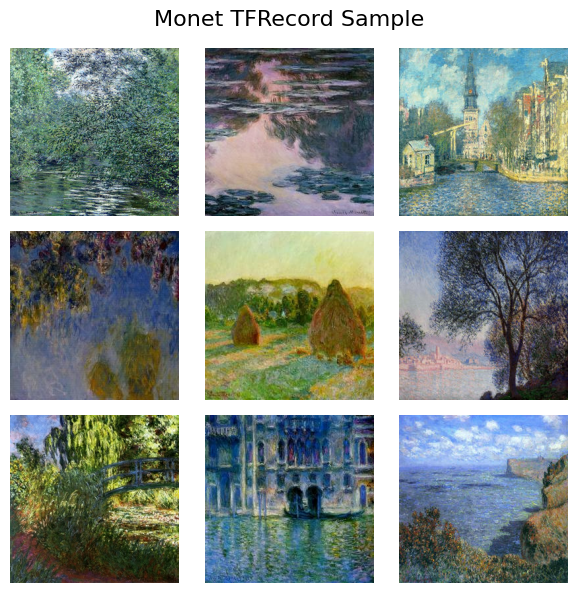

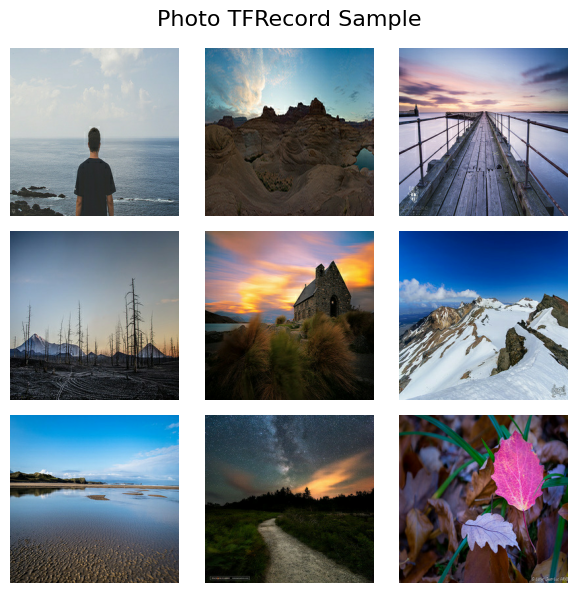

In [ ]:
# Preview images from TFRec datasets (parsed)
def show_batch_tfrec(dataset, title="Image Batch from TFRecord"):
    plt.figure(figsize=(6, 6))
    for batch in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            img = batch[i].numpy()
            plt.imshow(img)
            plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

show_batch_tfrec(monet_tfrec_ds, title="Monet TFRecord Sample")
show_batch_tfrec(photo_tfrec_ds, title="Photo TFRecord Sample")

In [ ]:
# Image sizes and mode
sample_monet = PILImage.open(os.path.join(monet_jpg_path, os.listdir(monet_jpg_path)[0]))
sample_photo = PILImage.open(os.path.join(photo_jpg_path, os.listdir(photo_jpg_path)[0]))

print("Monet JPG Size:", sample_monet.size, "| Mode:", sample_monet.mode)
print("Photo JPG Size:", sample_photo.size, "| Mode:", sample_photo.mode)

Monet JPG Size: (256, 256) | Mode: RGB
Photo JPG Size: (256, 256) | Mode: RGB


An analysis of the pixel distributions across color channels highlights a stylistic contrast between the two datasets. The RGB histograms for Monet paintings show roughly a bell-shaped distributions across all channels, suggesting a more balanced use of color. In comparison, the photo images exhibit more irregular distributions, indicating a dominance of lighter/darker tones or specific color channels in many areas.

This analysis confirms that there are significant stylistic and statistical differences between the Monet and photo datasets—information that will be crucial when training the GAN to learn and replicate Monet’s artistic style.

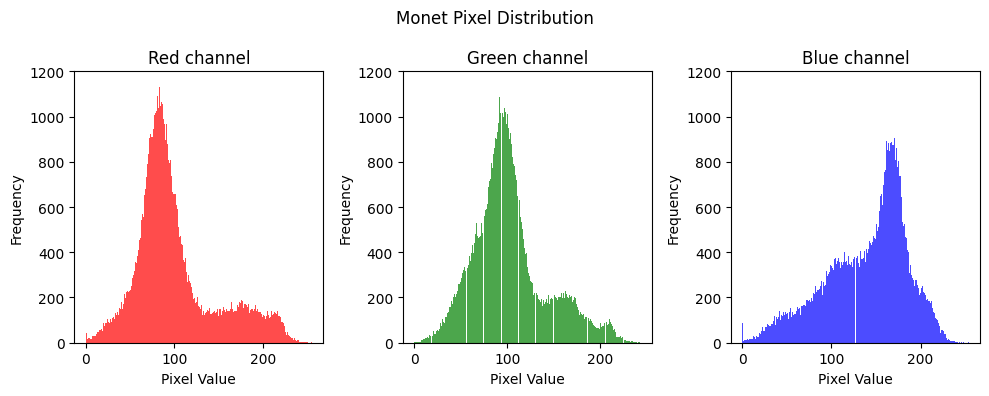

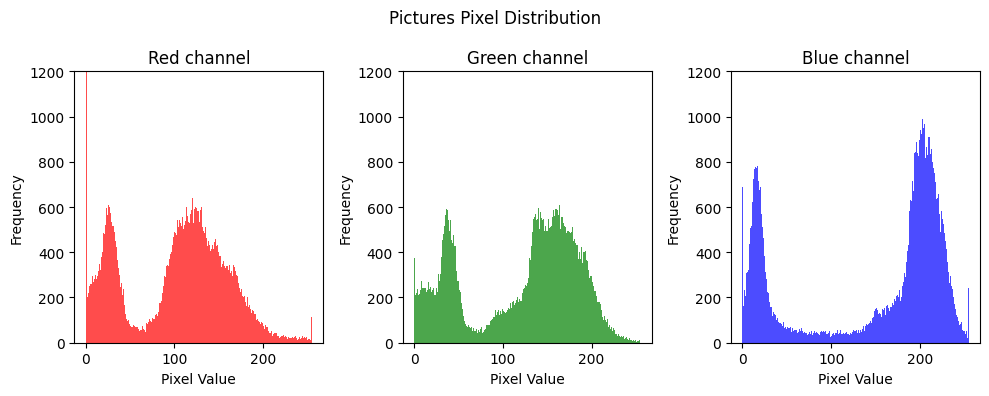

In [ ]:
# RGB channels distribution
def pixel_distrib_plot(image, title="Pixel Distribution"):
    image_array = np.array(image)
    plt.figure(figsize=(10, 4))
    for i, color in enumerate(['Red', 'Green', 'Blue']):
        plt.subplot(1, 3, i+1)
        plt.hist(image_array[..., i].ravel(), bins=256, color=color.lower(), alpha=0.7)
        plt.title(f"{color} channel")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        plt.ylim(0,1200)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

pixel_distrib_plot(sample_monet, title="Monet Pixel Distribution")
pixel_distrib_plot(sample_photo, title="Pictures Pixel Distribution")

In [ ]:
# RGB values
def channel_stats(dataset, num_batches=10):
    means, stds = [], []
    for batch in dataset.take(num_batches):
        arr = batch.numpy()
        means.append(np.mean(arr, axis=(0, 1, 2)))
        stds.append(np.std(arr, axis=(0, 1, 2)))
    mean = np.mean(means, axis=0)
    std = np.mean(stds, axis=0)
    return mean, std

monet_mean, monet_std = channel_stats(monet_tfrec_ds)
photo_mean, photo_std = channel_stats(photo_tfrec_ds)

print("Monet RGB Mean:", monet_mean)
print("Monet RGB Std:", monet_std)
print("Pictures RGB Mean:", photo_mean)
print("Pictures RGB Std:", photo_std)

Monet RGB Mean: [0.52569085 0.52817667 0.48131913]
Monet RGB Std: [0.22768633 0.218985   0.2453384 ]
Photo RGB Mean: [0.40459052 0.40161538 0.37297446]
Photo RGB Std: [0.27215594 0.24969411 0.27344292]


In [ ]:
# Values normalization and data augmentation
monet_mean = tf.constant([0.5223518, 0.52392614, 0.4775045])
monet_std = tf.constant([0.22598326, 0.21896291, 0.24682418])
photo_mean = tf.constant([0.40240398, 0.41256928, 0.39280397])
photo_std = tf.constant([0.27914193, 0.25308424, 0.28433564])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])

## Augmentation and Normalization

To improve the generalization ability of our model and make training more robust, we apply a set of data augmentation and normalization techniques. Augmentation basically introduces random transformations to the input images, such as horizontal flips and random cropping, simulating a wider variety of samples from a limited dataset. This is particularly important in image translation tasks, where capturing stylistic and structural variance helps the model learn more robust mappings.

Normalization is applied to rescale the pixel values to a standard range, which is crucial for stabilizing training, especially when using models like GANs that could be sensitive to input scale.

In [ ]:
# TFRecord Loader: Augmentation and Normalization
def load_dataset_augmented(directory, mean, std, image_size=(256, 256), batch_size=4):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }

    def _parse_function(proto):
        example = tf.io.parse_single_example(proto, feature_description)
        img = tf.io.decode_jpeg(example['image'], channels=3)
        img = tf.img.resize(img, image_size)
        img = tf.cast(img, tf.float32) / 255.0
        img = (img - mean) / std
        img = data_augmentation(img)
        return img

    tfrecord_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tfrec')]
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(500).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
monet_tfrec_ds = load_dataset_augmented(monet_tfrec_path, monet_mean, monet_std)
photo_tfrec_ds = load_dataset_augmented(photo_tfrec_path, photo_mean, photo_std)

# Definition of utilities and helpful functions

This section includes a collection of utility functions to simplify and modularize the training pipeline. These include functions for loading and decode images, generating visualizations, and managing checkpoints.

In particular:

*   Image loading functions that read .jpg files from disk and convert them to TensorFlow tensors.
*   Domain-specific preprocessing, including resizing and normalization to [−1,1][−1,1], consistent with the model's expectations.
*   Image sampling and plotting utilities, which are useful for visually assessing the model's progress during and after training.
*   Directory and file management utilities to streamline experiment tracking and reproducibility.

While not directly involved in the learning process, these functions are essential for structuring the pipeline, improving readability, and promoting good software engineering practices within the notebook

Image Decoding

In [ ]:
def decode_image(img):
    img = tf.img.decode_jpeg(img, channels=CHANNELS)
    img = (tf.cast(img, tf.float32) / 127.5) - 1
    img = tf.reshape(img, [HEIGHT, WIDTH, CHANNELS])
    return img

def read_tfrecord(example):
    tfrecord_format = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image':      tf.io.FixedLenFeature([], tf.string),
        'target':     tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    img = decode_image(example['image'])
    return img

Dataset Loading and Sample Display

In [ ]:
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)

    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)

    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()

    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))

    return gan_ds

def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)

        plt.subplot(121)
        plt.title("input image")
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')

        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()


## Model Functions

To construct our generator architecture, we define modular components that encapsulate common patterns in convolutional neural networks: downsampling and upsampling layers.

*  downsample() reduces the spatial dimensions while increasing the depth of the feature maps, allowing the network to extract increasingly abstract representations.

*  upsample() defines the transposed convolutional counterpart to downsample(). It increases spatial resolution, effectively reconstructing the image from compressed representations.

*  predict_and_save() allows us to generate translated images from a source domain and save them alongside the input and ground truth.

In [ ]:
def downsample(filters, size, apply_instancenorm=True, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(L.Conv2D(filters, size, strides=strides, padding='same',
                        kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tf.keras.layers.GroupNormalization(gamma_initializer=gamma_init, groups=-1))

    result.add(L.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(L.Conv2DTranspose(filters, size, strides=strides, padding='same',
                                 kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.GroupNormalization(gamma_initializer=gamma_init, groups=-1))

    if apply_dropout:
        result.add(L.Dropout(0.5))

    result.add(L.ReLU())

    return result

def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # prediction
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # rescaling
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

# Model Setup

## Generator Model


The generator network is responsible for translating images from one domain to another — for instance, from real-world photos to Monet-style paintings. In our implementation, the generator follows a symmetric encoder–decoder architecture:

*  The encoder consists of multiple convolutional layers with strides greater than one, effectively downsampling the input while capturing high-level semantic features.

*  The decoder uses transposed convolutions to upsample the intermediate representations back to the original image resolution.

*  Padding layers to reduce border artifacts, which are common in image generation tasks.

*  The final activation function is tanh, in order to ensure that the output image pixel values fall in a normalized range.


In [ ]:
OUTPUT_CHANNELS = 3

def generator_fn():
    inputs = L.Input(shape=[HEIGHT, WIDTH, CHANNELS])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4),                          # (bs, 64, 64, 128)
        downsample(256, 4),                          # (bs, 32, 32, 256)
        downsample(512, 4),                          # (bs, 16, 16, 512)
        downsample(512, 4),                          # (bs, 8, 8, 512)
        downsample(512, 4),                          # (bs, 4, 4, 512)
        downsample(512, 4),                          # (bs, 2, 2, 512)
        downsample(512, 4),                          # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4),                     # (bs, 16, 16, 1024)
        upsample(256, 4),                     # (bs, 32, 32, 512)
        upsample(128, 4),                     # (bs, 64, 64, 256)
        upsample(64, 4),                      # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = L.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                             strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and set skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = L.Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

## Discriminator

The discriminator network is responsible for telling apart real images from those generated by the model. In this implementation, the discriminator is built as a sequence of convolutional layers with increasing depth, which allows it to extract both low-level and high-level features from the input image.

In [ ]:
def discriminator_fn():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = L.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = L.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = L.Conv2D(512, 4, strides=1,
                    kernel_initializer=initializer,
                    use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tf.keras.layers.GroupNormalization(gamma_initializer=gamma_init, groups=-1)(conv)

    leaky_relu = L.LeakyReLU()(norm1)

    zero_pad2 = L.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = L.Conv2D(1, 4, strides=1,
                    kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return Model(inputs=inp, outputs=last)


## CycleGAN Model Building

The model setup enables unpaired image-to-image translation by training both directions: from photos to Monet-style paintings and vice versa.

Specifically, we instantiate two generators: one for each mapping direction (Photo → Monet and Monet → Photo).

Thereafter, two discriminators: one for each domain, evaluating the realism of generated images.

The CycleGAN framework leverages both adversarial losses (to encourage photorealism in the generated images) and cycle consistency losses (to ensure that translations preserve content and can be reversed).

In [ ]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
EPOCHS = 50
BATCH_SIZE = 1

In [ ]:
monet_generator = generator_fn() # pictures to Monet-like paintings
photo_generator = generator_fn() # Monet paintings to photo-like pictures

monet_discriminator = discriminator_fn() # distinguish between real Monet paintings and generated ones
photo_discriminator = discriminator_fn() # distinguish between real pics and generated ones


class CycleGan(Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, input real photos
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, input fake photos
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply gradients to optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            'monet_gen_loss': total_monet_gen_loss,
            'photo_gen_loss': total_photo_gen_loss,
            'monet_disc_loss': monet_disc_loss,
            'photo_disc_loss': photo_disc_loss
        }

## Loss Function Definition

In this section, we define the custom loss functions that guide the training of the CycleGAN model.

The total loss for CycleGAN combines several components. First is an Adversarial Loss to measures how well the generator is able to fool the discriminator. Then comes a Cycle Consistency Loss ensures that if we translate an image from one domain to the other and back again, we end up with the original image. Lastly, an Identity Loss encourages the generator to produce an image that is close to the input when given images from the target domain

In [ ]:
# Discriminator loss {0: fake, 1: real} (The discriminator loss is the average of real and generated loss)
def discriminator_loss(real, generated):
      real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

      generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

      total_disc_loss = real_loss + generated_loss

      return total_disc_loss * 0.5

# Generator loss
def generator_loss(generated):
      return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)


# Cycle consistency loss (measures if original photo and the 2-times transformed photo are similar to one another)
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
      loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

      return LAMBDA * loss1

# Identity loss (comparison between the image and its generator (i.e. picture with picture generator))
def identity_loss(real_image, same_image, LAMBDA):
      loss = tf.reduce_mean(tf.abs(real_image - same_image))
      return LAMBDA * 0.5 * loss

# Training phase

The training phase is responsible for the learning process of the CycleGAN model. At each iteration, the generators and discriminators are updated in an adversarial manner using the loss functions previously defined.

During training:

*  We sample batches of images from both the source and target domains.

*  The generators try to translate images between domains, while the discriminators learn to distinguish between real and generated images.

*  The cycle consistency loss is enforced by translating an image forward and then back again, comparing the result to the original.

*  Gradients are computed for all trainable variables, and model weights are updated using an optimizer such as Adam.

In [ ]:
MONET_FILENAMES = tf.io.gfile.glob(str(monet_tfrec_path + '/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(photo_tfrec_path + '/*.tfrec'))

# Generators set
monet_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

# Discriminators set
monet_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

# GAN set
gan_model = CycleGan(monet_generator, photo_generator,
                         monet_discriminator, photo_discriminator)

gan_model.compile(m_gen_optimizer=monet_generator_optimizer,
                      p_gen_optimizer=photo_generator_optimizer,
                      m_disc_optimizer=monet_discriminator_optimizer,
                      p_disc_optimizer=photo_discriminator_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss,
                      cycle_loss_fn=calc_cycle_loss,
                      identity_loss_fn=identity_loss)


history = gan_model.fit(get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, batch_size=BATCH_SIZE),
                        steps_per_epoch=(monet_count//BATCH_SIZE),
                        epochs=EPOCHS,
                        verbose=2).history


Epoch 1/50
300/300 - 134s - 446ms/step - monet_disc_loss: 0.7905 - monet_gen_loss: 3.4154 - photo_disc_loss: 0.6997 - photo_gen_loss: 3.6020
Epoch 2/50
300/300 - 62s - 207ms/step - monet_disc_loss: 0.7176 - monet_gen_loss: 2.9854 - photo_disc_loss: 0.6146 - photo_gen_loss: 3.1996
Epoch 3/50
300/300 - 62s - 208ms/step - monet_disc_loss: 0.8519 - monet_gen_loss: 3.0280 - photo_disc_loss: 0.9722 - photo_gen_loss: 2.8372
Epoch 4/50
300/300 - 62s - 208ms/step - monet_disc_loss: 0.7067 - monet_gen_loss: 2.8546 - photo_disc_loss: 0.5666 - photo_gen_loss: 3.9480
Epoch 5/50
300/300 - 62s - 208ms/step - monet_disc_loss: 0.4100 - monet_gen_loss: 3.2498 - photo_disc_loss: 0.2612 - photo_gen_loss: 2.9714
Epoch 6/50
300/300 - 62s - 207ms/step - monet_disc_loss: 0.3628 - monet_gen_loss: 3.1509 - photo_disc_loss: 0.3377 - photo_gen_loss: 3.2036
Epoch 7/50
300/300 - 62s - 207ms/step - monet_disc_loss: 0.5951 - monet_gen_loss: 2.2869 - photo_disc_loss: 0.6164 - photo_gen_loss: 2.5955
Epoch 8/50
300/300 

# Predictions and Submission

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


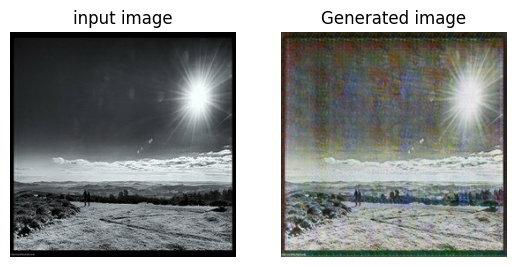

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


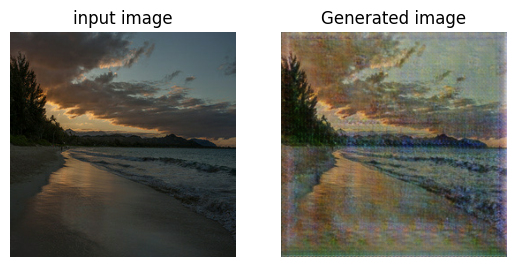

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


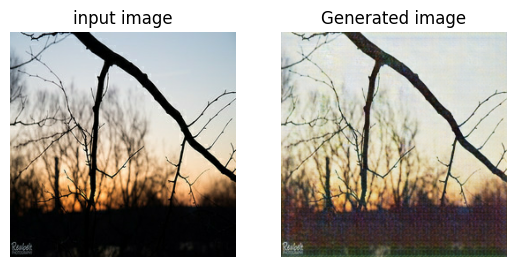

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


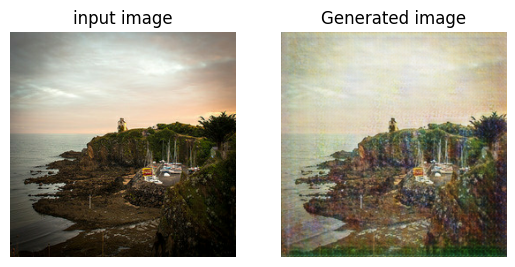

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


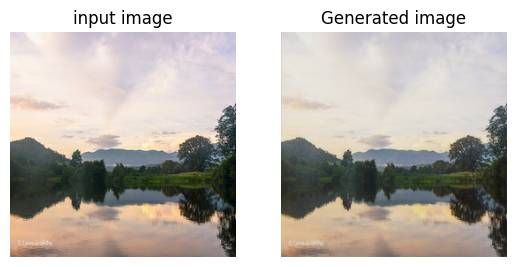

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


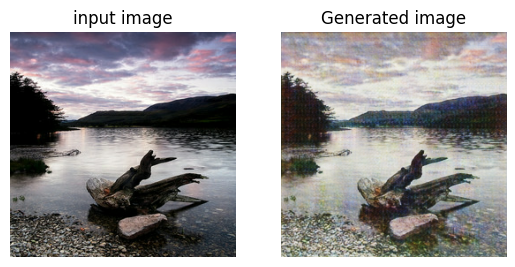

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


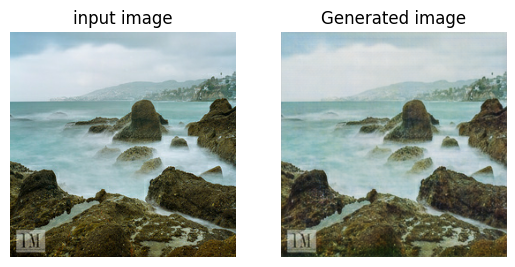

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


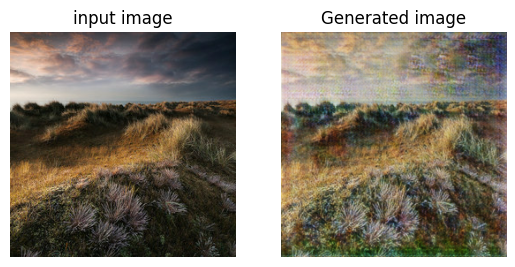

In [ ]:
display_generated_samples(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, 8)

Make and save predictions

In [ ]:
os.makedirs('../images/') # Directory with generated images
predict_and_save(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, '../images/')

Submission File

In [ ]:
shutil.make_archive('/kaggle/working/images', 'zip', '../images')
print(f"Generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")

Generated samples: 7038


# Conclusions

In this project, we successfully implemented a CycleGAN architecture to perform unpaired image-to-image translation between photographs and Monet-style paintings. After a data preprocessing and augmentation stage, model design, and the application of adversarial and cycle consistency losses, the model was able to generate convincing Monet-style renditions of natural images while preserving essential content.

The experiments demonstrate the effectiveness of CycleGAN in transferring a complex artistic style without requiring paired training data. The generated outputs capture the characteristic color palette and brushwork typical of Monet’s paintings, validating both the network design and training strategy.